# Анализ качества LLM-аннотаций (SGR)

Этот ноутбук делает быстрый аудит качества по файлу `out/annotations.jsonl`.

Что смотрим:
- качество определения роли спикера (`unit_speaker`),
- качество детекции эмпатии (`unit_empathy`) для `Sales Rep`,
- стабильность пайплайна (retry, validation errors),
- короткие выводы для бизнеса.


## 1) Setup и загрузка данных


In [1]:
from __future__ import annotations

import json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.max_colwidth", 120)

def find_annotations_file(filename: str = "annotations.jsonl") -> Path:
    # Ищем файл устойчиво: из корня repo, из папки notebooks и из родительских директорий.
    candidates = [
        Path("out") / filename,
        Path("../out") / filename,
        Path(filename),
    ]

    cwd = Path.cwd()
    for parent in [cwd, *list(cwd.parents)[:4]]:
        candidates.append(parent / "out" / filename)

    checked = []
    seen = set()
    for candidate in candidates:
        resolved = candidate.resolve()
        if resolved in seen:
            continue
        seen.add(resolved)
        checked.append(resolved)
        if resolved.exists():
            return resolved

    checked_text = "\n".join(f"- {p}" for p in checked)
    raise FileNotFoundError(f"Не найден {filename}. Проверены пути:\n{checked_text}")

DATA_PATH = find_annotations_file()
print(f"Файл данных: {DATA_PATH}")


Файл данных: /Users/ablackman/go/src/github.com/tetraminz/sales_protocol/out/annotations.jsonl


In [2]:
rows = []

with DATA_PATH.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        rec = json.loads(line)
        guided = rec.get("guided", {})

        speaker_unit = guided.get("unit_speaker", {})
        speaker_out = speaker_unit.get("output") or {}
        speaker_quote = (speaker_out.get("evidence") or {}).get("quote", "")

        empathy_unit = guided.get("unit_empathy", {})
        empathy_out = empathy_unit.get("output") or {}
        empathy_evidence = empathy_out.get("evidence") or []
        empathy_first_quote = empathy_evidence[0].get("quote", "") if empathy_evidence else ""

        replica_text = rec.get("replica_text", "")

        rows.append({
            "conversation_id": rec.get("conversation_id"),
            "replica_id": rec.get("replica_id"),
            "speaker_true": rec.get("speaker_true"),
            "replica_text": replica_text,

            "speaker_ok": bool(speaker_unit.get("ok", False)),
            "speaker_attempts": int(speaker_unit.get("attempts", 0)),
            "speaker_validation_errors_n": len(speaker_unit.get("validation_errors") or []),
            "speaker_predicted": speaker_out.get("predicted_speaker"),
            "speaker_confidence": speaker_out.get("confidence"),
            "speaker_quote": speaker_quote,
            "speaker_quote_in_text": bool(speaker_quote) and (speaker_quote in replica_text),

            "empathy_ran": bool(empathy_unit.get("ran", False)),
            "empathy_ok": bool(empathy_unit.get("ok", False)),
            "empathy_attempts": int(empathy_unit.get("attempts", 0)),
            "empathy_validation_errors_n": len(empathy_unit.get("validation_errors") or []),
            "empathy_present": empathy_out.get("empathy_present"),
            "empathy_type": empathy_out.get("empathy_type"),
            "empathy_confidence": empathy_out.get("confidence"),
            "empathy_first_quote": empathy_first_quote,
            "empathy_first_quote_in_text": bool(empathy_first_quote) and (empathy_first_quote in replica_text),

            "request_ids_n": len((rec.get("meta", {}).get("openai_request_ids") or [])),
        })

df = pd.DataFrame(rows)
df["speaker_confidence"] = pd.to_numeric(df["speaker_confidence"], errors="coerce")
df["empathy_confidence"] = pd.to_numeric(df["empathy_confidence"], errors="coerce")

print(f"Загружено строк: {len(df)}")
display(df.head(3))


Загружено строк: 396


,conversation_id,replica_id,speaker_true,replica_text,speaker_ok,speaker_attempts,speaker_validation_errors_n,speaker_predicted,speaker_confidence,speaker_quote,...,empathy_ran,empathy_ok,empathy_attempts,empathy_validation_errors_n,empathy_present,empathy_type,empathy_confidence,empathy_first_quote,empathy_first_quote_in_text,request_ids_n
0,modamart__0_transcript,1,Sales Rep,"Hi there! Thank you for taking the time to speak with me today. My name is Jamie, and I’m a sales representative fro...",True,1,0,Sales Rep,0.99,"My name is Jamie, and I’m a sales representative from ModaMart.",...,True,True,1,0,True,validation,0.8,How are you today?,True,2
1,modamart__0_transcript,2,Customer,"Hi Jamie. I'm doing well, thanks. How about you?",True,1,0,Customer,0.99,"Hi Jamie. I'm doing well, thanks. How about you?",...,False,True,0,0,False,none,0.0,,False,1
2,modamart__0_transcript,3,Sales Rep,"I’m great, thank you! So, I understand you’ve been browsing our online store. Is there anything specific you’re look...",True,1,0,Sales Rep,0.95,"I’m great, thank you! So, I understand you’ve been browsing our online store. Is there anything specific you’re look...",...,True,True,1,0,True,validation,0.7,"I’m great, thank you!",True,2


In [3]:
n_replicas = len(df)
n_conversations = df["conversation_id"].nunique()
sales_share = (df["speaker_true"] == "Sales Rep").mean() if n_replicas else np.nan

print(f"Реплик: {n_replicas}")
print(f"Диалогов: {n_conversations}")
print(f"Доля реплик Sales Rep: {sales_share:.1%}")

display(df[["conversation_id", "replica_id", "speaker_true"]].head(10))


Реплик: 396
Диалогов: 20
Доля реплик Sales Rep: 51.8%


,conversation_id,replica_id,speaker_true
0,modamart__0_transcript,1,Sales Rep
1,modamart__0_transcript,2,Customer
2,modamart__0_transcript,3,Sales Rep
3,modamart__0_transcript,4,Customer
4,modamart__0_transcript,5,Sales Rep
5,modamart__0_transcript,6,Customer
6,modamart__0_transcript,7,Sales Rep
7,modamart__0_transcript,8,Customer
8,modamart__0_transcript,9,Sales Rep
9,modamart__0_transcript,10,Customer


## 2) Unit A: качество speaker attribution

Считаем:
- точность определения спикера,
- частоту retry,
- частоту validation ошибок,
- кейсы, где модель ошиблась или не вернула валидный output.


In [4]:
df["speaker_predicted_filled"] = df["speaker_predicted"].fillna("NO_PREDICTION")
df["speaker_correct"] = df["speaker_predicted_filled"] == df["speaker_true"]

speaker_accuracy = df["speaker_correct"].mean() if len(df) else np.nan
speaker_ok_rate = df["speaker_ok"].mean() if len(df) else np.nan
speaker_retry_rate = (df["speaker_attempts"] > 1).mean() if len(df) else np.nan
speaker_validation_rate = (df["speaker_validation_errors_n"] > 0).mean() if len(df) else np.nan

print(f"Speaker accuracy: {speaker_accuracy:.2%}")
print(f"Speaker ok rate: {speaker_ok_rate:.2%}")
print(f"Speaker retry rate: {speaker_retry_rate:.2%}")
print(f"Speaker validation error rate: {speaker_validation_rate:.2%}")

conf = pd.crosstab(df["speaker_true"], df["speaker_predicted_filled"], margins=True)
display(conf)

problem_speaker = df[(~df["speaker_correct"]) | (~df["speaker_ok"])][[
    "conversation_id",
    "replica_id",
    "speaker_true",
    "speaker_predicted_filled",
    "speaker_ok",
    "speaker_attempts",
    "speaker_validation_errors_n",
]]

print("Проблемные реплики (speaker):")
display(problem_speaker.head(10))


Speaker accuracy: 97.73%
Speaker ok rate: 98.99%
Speaker retry rate: 2.27%
Speaker validation error rate: 2.27%


speaker_predicted_filled,Customer,NO_PREDICTION,Sales Rep,All
speaker_true,,,,
Customer,191,0,0,191
Sales Rep,5,4,196,205
All,196,4,196,396


Проблемные реплики (speaker):


,conversation_id,replica_id,speaker_true,speaker_predicted_filled,speaker_ok,speaker_attempts,speaker_validation_errors_n
75,modamart__3_transcript,17,Sales Rep,Customer,True,4,4
112,modamart__5_transcript,17,Sales Rep,NO_PREDICTION,False,3,3
131,modamart__6_transcript,19,Sales Rep,Customer,True,2,1
218,nexiv-solutions__0_transcript,25,Sales Rep,NO_PREDICTION,False,3,3
275,nexiv-solutions__3_transcript,21,Sales Rep,Customer,True,4,4
296,nexiv-solutions__4_transcript,21,Sales Rep,NO_PREDICTION,False,3,3
356,nexiv-solutions__7_transcript,25,Sales Rep,Customer,True,2,1
374,nexiv-solutions__8_transcript,17,Sales Rep,Customer,True,2,1
376,nexiv-solutions__8_transcript,19,Sales Rep,NO_PREDICTION,False,3,3


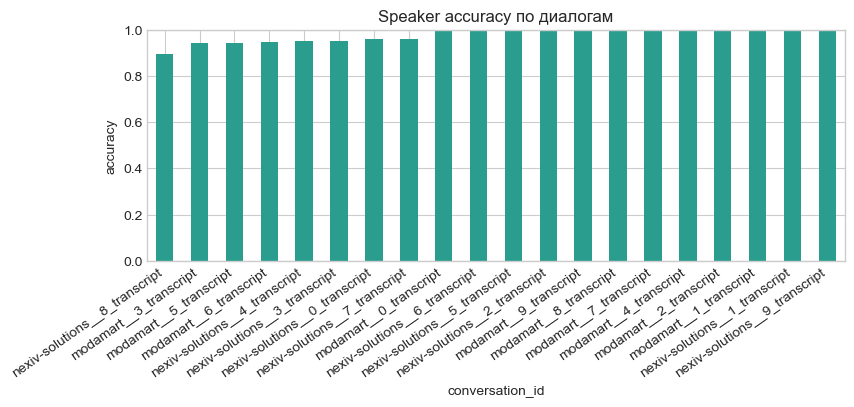

,speaker_accuracy
conversation_id,
nexiv-solutions__8_transcript,0.894737
modamart__3_transcript,0.941176
modamart__5_transcript,0.941176
modamart__6_transcript,0.947368
nexiv-solutions__4_transcript,0.952381
nexiv-solutions__3_transcript,0.952381
nexiv-solutions__0_transcript,0.960000
nexiv-solutions__7_transcript,0.961538
modamart__0_transcript,1.000000


In [5]:
conv_acc = df.groupby("conversation_id")["speaker_correct"].mean().sort_values()

ax = conv_acc.plot(kind="bar", figsize=(9, 3), color="#2a9d8f")
ax.set_ylim(0, 1)
ax.set_title("Speaker accuracy по диалогам")
ax.set_ylabel("accuracy")
plt.xticks(rotation=35, ha="right")
plt.show()

display(conv_acc.to_frame("speaker_accuracy"))


## 3) Unit B: качество empathy detection

По ТЗ юнит работает только для `Sales Rep`, поэтому метрики считаем только на этом срезе.


Реплик Sales Rep: 205
Empathy coverage (ran=true): 100.00%
Empathy ok rate: 100.00%
Доля реплик с эмпатией: 75.12%
Empathy retry rate: 0.49%
Empathy validation error rate: 0.49%


,share
empathy_type,
validation,0.356098
none,0.248780
support,0.243902
reassurance,0.131707
apology,0.019512


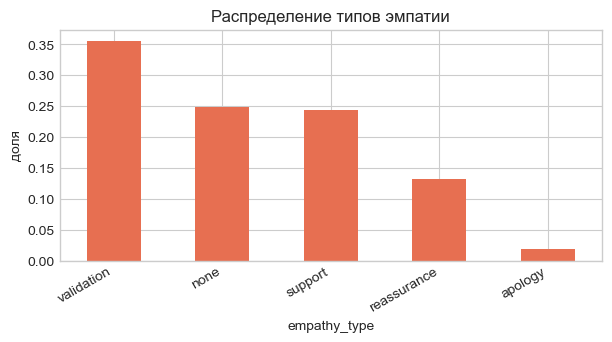

In [6]:
sales_df = df[df["speaker_true"] == "Sales Rep"].copy()

if len(sales_df) == 0:
    print("Нет реплик Sales Rep, блок empathy пропущен")
else:
    empathy_coverage = sales_df["empathy_ran"].mean()
    empathy_ok_rate = sales_df["empathy_ok"].mean()
    empathy_present_rate = sales_df["empathy_present"].fillna(False).mean()
    empathy_retry_rate = (sales_df["empathy_attempts"] > 1).mean()
    empathy_validation_rate = (sales_df["empathy_validation_errors_n"] > 0).mean()

    empathy_type_dist = (
        sales_df["empathy_type"]
        .fillna("unknown")
        .value_counts(normalize=True)
        .rename("share")
    )

    print(f"Реплик Sales Rep: {len(sales_df)}")
    print(f"Empathy coverage (ran=true): {empathy_coverage:.2%}")
    print(f"Empathy ok rate: {empathy_ok_rate:.2%}")
    print(f"Доля реплик с эмпатией: {empathy_present_rate:.2%}")
    print(f"Empathy retry rate: {empathy_retry_rate:.2%}")
    print(f"Empathy validation error rate: {empathy_validation_rate:.2%}")

    display(empathy_type_dist.to_frame())

    ax = empathy_type_dist.sort_values(ascending=False).plot(kind="bar", figsize=(7, 3), color="#e76f51")
    ax.set_title("Распределение типов эмпатии")
    ax.set_ylabel("доля")
    plt.xticks(rotation=30, ha="right")
    plt.show()


## 4) KPI и бизнес-выводы

Ниже короткий summary, который можно отдавать в weekly-апдейт.


In [7]:
def pct(v: float) -> str:
    if pd.isna(v):
        return "n/a"
    return f"{100 * v:.1f}%"

def wilson_lower(successes: int, total: int, z: float = 1.96) -> float:
    # Нижняя граница Wilson CI для доли успехов (95% при z=1.96).
    if total == 0:
        return np.nan
    p = successes / total
    denom = 1 + (z * z) / total
    center = p + (z * z) / (2 * total)
    margin = z * np.sqrt((p * (1 - p) + (z * z) / (4 * total)) / total)
    return (center - margin) / denom

# Общие KPI
speaker_accuracy = df["speaker_correct"].mean() if len(df) else np.nan
speaker_ok_rate = df["speaker_ok"].mean() if len(df) else np.nan
speaker_retry_rate = (df["speaker_attempts"] > 1).mean() if len(df) else np.nan
speaker_evidence_ok = df["speaker_quote_in_text"].mean() if len(df) else np.nan

sales_df = df[df["speaker_true"] == "Sales Rep"].copy()
empathy_present_rate = sales_df["empathy_present"].fillna(False).mean() if len(sales_df) else np.nan
empathy_retry_rate = (sales_df["empathy_attempts"] > 1).mean() if len(sales_df) else np.nan
empathy_evidence_ok = sales_df["empathy_first_quote_in_text"].mean() if len(sales_df) else np.nan

kpi = pd.DataFrame({
    "KPI": [
        "Диалогов",
        "Реплик",
        "Speaker accuracy",
        "Speaker ok rate",
        "Speaker retry rate",
        "Speaker evidence quote in text",
        "Empathy present rate (Sales Rep)",
        "Empathy retry rate (Sales Rep)",
        "Empathy first quote in text (Sales Rep)",
        "Среднее число request_id на реплику",
    ],
    "Значение": [
        int(df["conversation_id"].nunique()),
        int(len(df)),
        pct(speaker_accuracy),
        pct(speaker_ok_rate),
        pct(speaker_retry_rate),
        pct(speaker_evidence_ok),
        pct(empathy_present_rate),
        pct(empathy_retry_rate),
        pct(empathy_evidence_ok),
        round(df["request_ids_n"].mean(), 2) if len(df) else np.nan,
    ],
})
display(kpi)

# Индуктивная схема (от общего к частному):
# Общий порог качества для диалога
T_ACC = 0.95
T_OK = 1.00

conv_stats = df.groupby("conversation_id").agg(
    n_replicas=("replica_id", "count"),
    speaker_accuracy=("speaker_correct", "mean"),
    speaker_ok_rate=("speaker_ok", "mean"),
).sort_index()

conv_stats["local_condition"] = (
    (conv_stats["speaker_accuracy"] >= T_ACC)
    & (conv_stats["speaker_ok_rate"] >= T_OK)
)

# Статистический слой: нижняя 95% граница для общей speaker-accuracy.
speaker_success = int(df["speaker_correct"].sum())
speaker_total = int(len(df))
speaker_wilson_lb = wilson_lower(speaker_success, speaker_total)

display(conv_stats)

# Формулируем вывод строго: сначала общий принцип, потом проверка на данных.
print("1) Общий принцип (индукция): если в каждом диалоге выполняется локальное условие")
print("   (accuracy >= 95% и ok_rate = 100%), то и средняя accuracy по любому числу диалогов >= 95%.")

if len(conv_stats):
    first_conv = conv_stats.index[0]
    base_ok = bool(conv_stats.iloc[0]["local_condition"])
    print(f"2) База индукции (n=1, {first_conv}): local_condition={base_ok}.")

all_local_ok = bool(conv_stats["local_condition"].all()) if len(conv_stats) else False
print("3) Шаг индукции: при добавлении (k+1)-го диалога среднее остаётся >= 95%,")
print("   если новый диалог тоже удовлетворяет локальному условию.")

if all_local_ok:
    print("4) Частный вывод по текущей выборке: предпосылка выполнена для всех диалогов,")
    print("   значит по индукции общий KPI speaker устойчиво держится не ниже 95%.")
else:
    bad = conv_stats[~conv_stats["local_condition"]]
    print("4) Частный вывод по текущей выборке: предпосылка индукции нарушена (есть диалоги ниже порога).")
    print(f"   Диалогов с нарушением: {len(bad)} из {len(conv_stats)}.")

print(f"5) Статистический контроль: общая speaker accuracy={pct(speaker_accuracy)},")
print(f"   нижняя 95% граница Wilson={pct(speaker_wilson_lb)}.")

print("6) Бизнес-интерпретация (от общего к частному):")
if pd.notna(speaker_wilson_lb) and speaker_wilson_lb >= 0.90:
    print("   - Риск ошибочной авторазметки ролей умеренный: решение можно использовать в операционной аналитике.")
else:
    print("   - Риск ошибочной авторазметки ролей заметный: для критичных отчетов нужна ручная валидация.")

if len(sales_df):
    print(f"   - Эмпатия в речи продавца: {pct(empathy_present_rate)} реплик.")
    print("   - Это KPI для coaching: низкие значения сигналят о риске снижения конверсии и NPS.")

print("   - Выборка пока небольшая; используем вывод как ранний сигнал, не как финальный аудит.")


,KPI,Значение
0,Диалогов,20
1,Реплик,396
2,Speaker accuracy,97.7%
3,Speaker ok rate,99.0%
4,Speaker retry rate,2.3%
5,Speaker evidence quote in text,99.0%
6,Empathy present rate (Sales Rep),75.1%
7,Empathy retry rate (Sales Rep),0.5%
8,Empathy first quote in text (Sales Rep),75.1%
9,Среднее число request_id на реплику,1.56


,n_replicas,speaker_accuracy,speaker_ok_rate,local_condition
conversation_id,,,,
modamart__0_transcript,19,1.000000,1.000000,True
modamart__1_transcript,20,1.000000,1.000000,True
modamart__2_transcript,20,1.000000,1.000000,True
modamart__3_transcript,17,0.941176,1.000000,False
modamart__4_transcript,20,1.000000,1.000000,True
modamart__5_transcript,17,0.941176,0.941176,False
modamart__6_transcript,19,0.947368,1.000000,False
modamart__7_transcript,18,1.000000,1.000000,True
modamart__8_transcript,23,1.000000,1.000000,True


1) Общий принцип (индукция): если в каждом диалоге выполняется локальное условие
   (accuracy >= 95% и ok_rate = 100%), то и средняя accuracy по любому числу диалогов >= 95%.
2) База индукции (n=1, modamart__0_transcript): local_condition=True.
3) Шаг индукции: при добавлении (k+1)-го диалога среднее остаётся >= 95%,
   если новый диалог тоже удовлетворяет локальному условию.
4) Частный вывод по текущей выборке: предпосылка индукции нарушена (есть диалоги ниже порога).
   Диалогов с нарушением: 6 из 20.
5) Статистический контроль: общая speaker accuracy=97.7%,
   нижняя 95% граница Wilson=95.7%.
6) Бизнес-интерпретация (от общего к частному):
   - Риск ошибочной авторазметки ролей умеренный: решение можно использовать в операционной аналитике.
   - Эмпатия в речи продавца: 75.1% реплик.
   - Это KPI для coaching: низкие значения сигналят о риске снижения конверсии и NPS.
   - Выборка пока небольшая; используем вывод как ранний сигнал, не как финальный аудит.


## 5) Что делать дальше

- Увеличить выборку минимум до 50-100 диалогов и пересчитать KPI.
- Добавить разметку по бизнес-исходу (например, был ли апселл/конверсия) и проверить связь с эмпатией.
- Для проблемных реплик собрать небольшой error-bank и уточнить промпты/правила валидации.
